In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
colors = plt.cm.tab10.colors  # 10 distinct colors
color_map = {i: colors[i-1] for i in range(1, 8)}

In [3]:
ids = [1, 2, 5, 6, 7]  # the actual files you have
dfs = {i: pd.read_csv(f"halpha results/WB{i}_orth_halpha_results.csv") for i in ids}

In [4]:
center_pixels = {
    1: 190,
    2: 196,
    5: 203,
    6: 189,
    7: 189,}

bar_lengths = {
    1: 2.069913304,
    2: 4.217194803,
    3: 1.96915261,
    4: 3.266140464,
    5: 1.859520678,
    6: 3.899131707,
    7: 2.481995787,
}


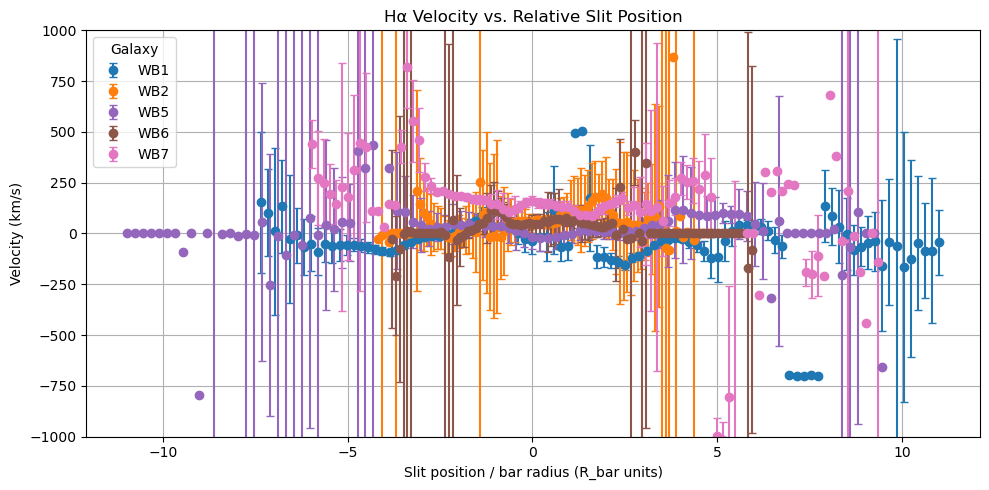

In [5]:
# --- Velocity plot ---
fig, ax = plt.subplots(figsize=(10,5))
for i, df in dfs.items():
    x_rel = (df["center"] - center_pixels[i]) * 0.4  # arcsec
    x_scaled = x_rel / bar_lengths[i]                # normalized by bar radius

    ax.errorbar(
        x_scaled, df["velocity"], yerr=df["velocity_err"],
        fmt="o", capsize=3, label=f"WB{i}", color=color_map[i]
    )

ax.set_ylim(-1000, 1000)
ax.set_xlabel("Slit position / bar radius (R_bar units)")  # <- if using x_scaled
# ax.set_xlabel("Distance from center (arcsec)")            # <- if using x_rel instead
ax.set_ylabel("Velocity (km/s)")
ax.set_title("Hα Velocity vs. Relative Slit Position")
ax.legend(title="Galaxy")
ax.grid(True)
fig.tight_layout()


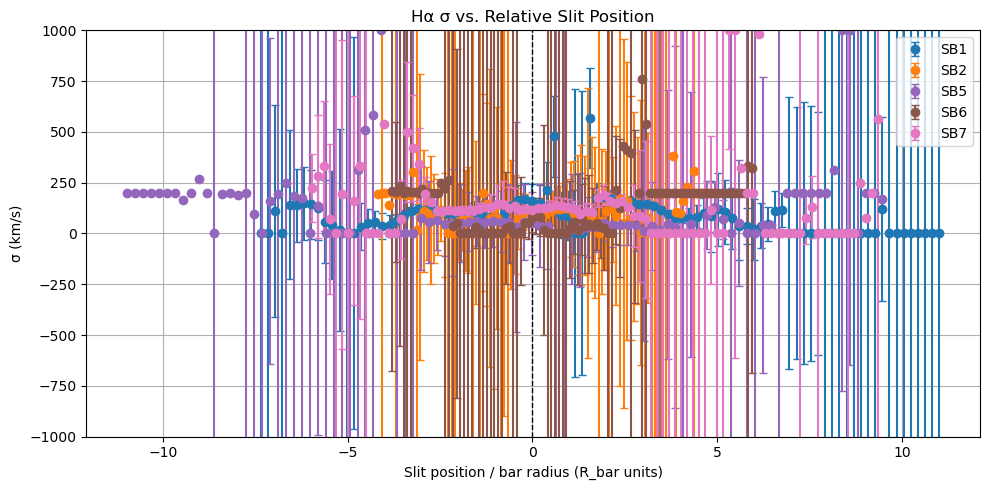

In [6]:
# --- Dispersion plot ---
fig, ax = plt.subplots(figsize=(10,5))
for i, df in dfs.items():
    x_rel = (df["center"] - center_pixels[i]) *0.4
    x_scaled = x_rel / bar_lengths[i]
    ax.errorbar(
        x_scaled, df["dispersion"], yerr=df["dispersion_err"],
        fmt="o", capsize=3, label=f"SB{i}" , color=color_map[i])
ax.set_ylim(-1000,1000)

ax.set_xlabel("Slit position / bar radius (R_bar units)") 
ax.set_ylabel("σ (km/s)")
ax.set_title("Hα σ vs. Relative Slit Position")
ax.axvline(0, color="black", ls="--", lw=1)
ax.legend()
ax.grid(True)
fig.tight_layout()

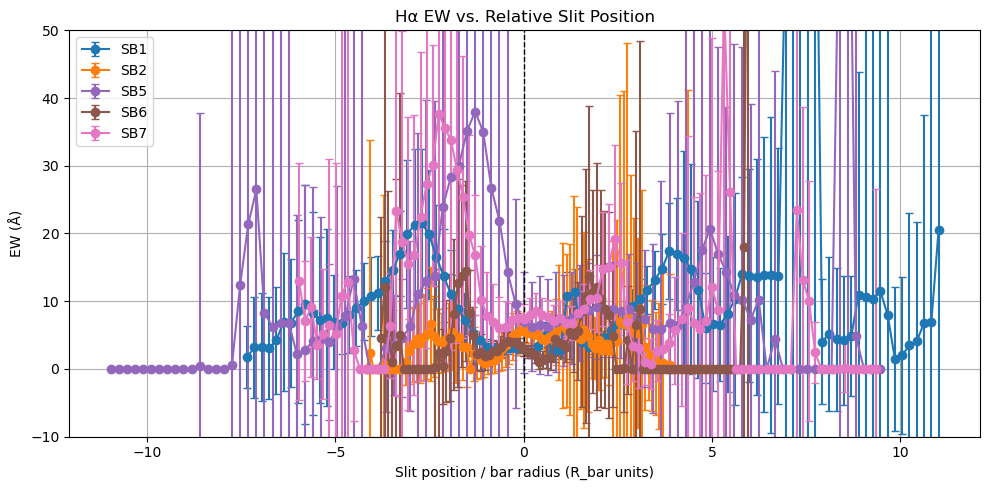

In [7]:
# --- Equivalent Width plot ---
fig, ax = plt.subplots(figsize=(10,5))
for i, df in dfs.items():
    x_rel = (df["center"] - center_pixels[i]) *0.4
    x_scaled = x_rel / bar_lengths[i]
    ax.errorbar(
        x_scaled, df["EW"], yerr=df["EW_err"],
        fmt="o-", capsize=3, label=f"SB{i}",  color=color_map[i])
    
ax.set_ylim(-10,50)
ax.set_xlabel("Slit position / bar radius (R_bar units)") 
ax.set_ylabel("EW (Å)")
ax.set_title("Hα EW vs. Relative Slit Position")
ax.axvline(0, color="black", ls="--", lw=1)
ax.legend()
ax.grid(True)
fig.tight_layout()


In [8]:
def weighted_mean(values, errors, mask):
    vals  = values[mask]
    errs  = errors[mask]
    if np.any(mask) and np.all(errs > 0):
        weights = 1 / errs**2
        mean = np.sum(weights * vals) / np.sum(weights)
        mean_err = np.sqrt(1 / np.sum(weights))
        return mean, mean_err
    return np.nan, np.nan


In [9]:
rows = []

for i, df in dfs.items():
    x_rel = (df["center"] - center_pixels[i]) * 0.4  # arcsec
    x_scaled = x_rel / bar_lengths[i]
    abs_x = np.abs(x_scaled)

    center_mask = (abs_x < 0.2)
    bar_mask    = (abs_x >= 0.2) & (abs_x < 0.8)
    out_mask    = (abs_x >= 0.8) & (abs_x <= 1.2)

    v_c, v_c_err = weighted_mean(np.abs(df["velocity"]), df["velocity_err"], center_mask)
    v_b, v_b_err = weighted_mean(np.abs(df["velocity"]), df["velocity_err"], bar_mask)
    v_o, v_o_err = weighted_mean(np.abs(df["velocity"]), df["velocity_err"], out_mask)

    σ_c, σ_c_err = weighted_mean(df["dispersion"], df["dispersion_err"], center_mask)
    σ_b, σ_b_err = weighted_mean(df["dispersion"], df["dispersion_err"], bar_mask)
    σ_o, σ_o_err = weighted_mean(df["dispersion"], df["dispersion_err"], out_mask)

    EW_c, EW_c_err = weighted_mean(df["EW"], df["EW_err"], center_mask)
    EW_b, EW_b_err = weighted_mean(df["EW"], df["EW_err"], bar_mask)
    EW_o, EW_o_err = weighted_mean(df["EW"], df["EW_err"], out_mask)

    rows.append({
        "WB": i,
        "v_center": v_c, "v_center_err": v_c_err,
        "v_bar": v_b,    "v_bar_err": v_b_err,
        "v_out": v_o,    "v_out_err": v_o_err,
        "σ_center": σ_c, "σ_center_err": σ_c_err,
        "σ_bar": σ_b,    "σ_bar_err": σ_b_err,
        "σ_out": σ_o,    "σ_out_err": σ_o_err,
        "EW_center": EW_c, "EW_center_err": EW_c_err,
        "EW_bar": EW_b,    "EW_bar_err": EW_b_err,
        "EW_out": EW_o,    "EW_out_err": EW_o_err,
    })

summary_df = pd.DataFrame(rows)


In [10]:
summary_df

,WB,v_center,v_center_err,v_bar,v_bar_err,v_out,v_out_err,σ_center,σ_center_err,σ_bar,σ_bar_err,σ_out,σ_out_err,EW_center,EW_center_err,EW_bar,EW_bar_err,EW_out,EW_out_err
0,1,27.247173,37.530275,62.655029,27.002059,439.729017,8.823136,161.254601,48.702517,147.612241,38.470976,78.974970,43.806173,2.795390,0.531465,2.976814,0.440544,3.671769,0.728153
1,2,63.118955,14.045262,56.873590,14.115014,88.667940,53.811458,99.434306,22.481731,101.576965,22.750626,119.134549,81.447445,5.352516,0.856869,4.068804,0.608598,1.433626,0.984010
2,5,16.864451,59.161791,18.102718,27.528721,17.399783,26.341968,50.328389,154.007403,47.076297,96.646592,54.592057,91.560635,6.892092,7.467393,6.563360,3.860030,7.108410,4.973198
3,6,47.835160,22.905787,48.315748,12.746882,77.326538,22.771648,73.328332,46.850365,58.245939,51.791362,44.722331,130.595004,2.934809,0.581516,2.527752,0.379169,2.888940,0.750389
4,7,154.754269,13.216199,139.721709,12.203368,126.878144,14.880438,118.299687,19.397575,128.298566,17.143140,130.019823,20.794407,7.553417,1.339014,7.542992,1.177203,7.187405,1.307504


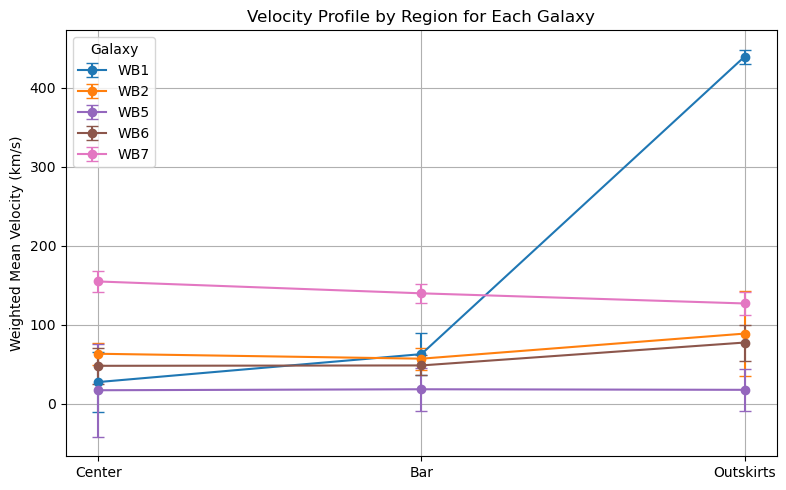

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

x_labels = ["Center", "Bar", "Outskirts"]
x_pos = np.arange(len(x_labels))

for _, row in summary_df.iterrows():
    wb_id = int(row['WB'])  # galaxy ID from dataframe
    
    velocities = [row["v_center"], row["v_bar"], row["v_out"]]
    errors     = [row["v_center_err"], row["v_bar_err"], row["v_out_err"]]
    
    ax.errorbar(
        x_pos, velocities, yerr=errors,
        marker='o', capsize=4,
        label=f"WB{wb_id}", color=color_map[wb_id]
    )

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Weighted Mean Velocity (km/s)")
ax.set_title("Velocity Profile by Region for Each Galaxy")
ax.legend(title="Galaxy")
ax.grid(True)

plt.tight_layout()
plt.show()


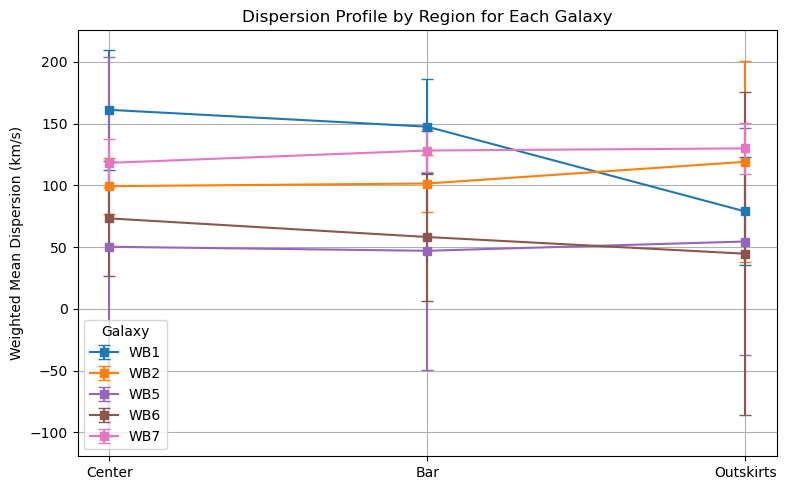

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

x_labels = ["Center", "Bar", "Outskirts"]
x_pos = np.arange(len(x_labels))

for _, row in summary_df.iterrows():
    wb_id = int(row['WB'])  # get galaxy ID from dataframe
    
    dispersions = [row["σ_center"], row["σ_bar"], row["σ_out"]]
    errors      = [row["σ_center_err"], row["σ_bar_err"], row["σ_out_err"]]
    
    ax.errorbar(
        x_pos, dispersions, yerr=errors,
        marker='s', capsize=4, label=f"WB{wb_id}", color=color_map[wb_id]
    )

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Weighted Mean Dispersion (km/s)")
ax.set_title("Dispersion Profile by Region for Each Galaxy")
ax.legend(title="Galaxy")
ax.grid(True)

plt.tight_layout()
plt.show()


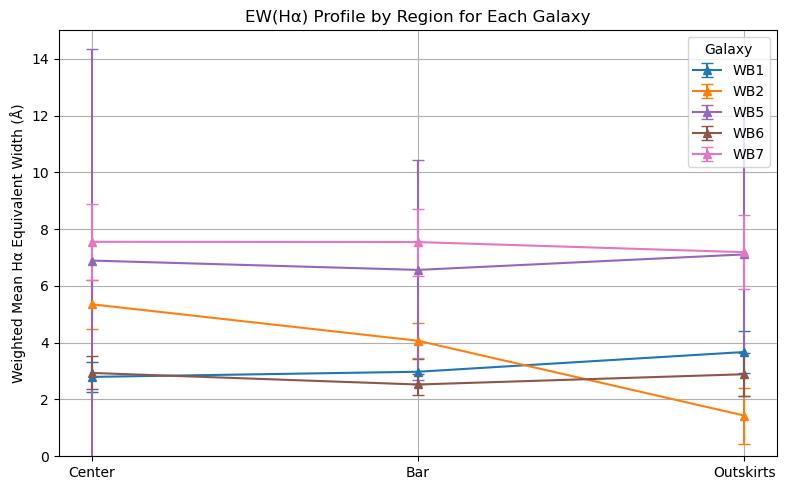

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

for _, row in summary_df.iterrows():
    wb_id = int(row['WB'])  # get galaxy ID from dataframe
    
    ews    = [row["EW_center"], row["EW_bar"], row["EW_out"]]
    errors = [row["EW_center_err"], row["EW_bar_err"], row["EW_out_err"]]
    
    ax.errorbar(
        x_pos, ews, yerr=errors,
        marker='^', capsize=4, label=f"WB{wb_id}", color=color_map[wb_id]
    )

ax.set_xticks(x_pos)
ax.set_ylim(0, 15)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Weighted Mean Hα Equivalent Width (Å)")
ax.set_title("EW(Hα) Profile by Region for Each Galaxy")
ax.legend(title="Galaxy")
ax.grid(True)

plt.tight_layout()
plt.show()
